# Q-Learning

In [1]:
!pip install --upgrade numpy==1.26.4
!pip uninstall tensorflow -y 
!pip install tensorflow==2.16.2 
%pip install gym

In [1]:
import os 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [2]:
import sys 
sys.setrecursionlimit(1500) 

import gym 
import numpy as np

## Create the Environment and Model

In [3]:
env = gym.make('CartPole-v1') 
np.random.seed(42) 
env.action_space.seed(42) 
env.observation_space.seed(42)

[42]

In [4]:
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gym

2025-05-26 10:30:44.566135: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 10:30:44.569882: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 10:30:44.582071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 10:30:44.606244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 10:30:44.606289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 10:30:44.621633: I tensorflow/core/platform/cpu_feature_guard.cc:

In [5]:
def build_model(state_size, action_size): 
    model = Sequential() 
    model.add(Input(shape=(state_size,)))
    model.add(Dense(24, activation='relu')) 
    model.add(Dense(24, activation='relu')) 
    model.add(Dense(action_size, activation='linear')) 
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001)) 
    return model 

In [6]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0] 
action_size = env.action_space.n 
model = build_model(state_size, action_size)

## Implement the Q-Learning Algorithm

In [7]:
import random
import numpy as np
from collections import deque
import tensorflow as tf

In [8]:
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99

memory = deque(maxlen=2000)

In [9]:
def remember(state, action, reward, next_state, done):
    """Store experience in memory."""
    memory.append((state, action, reward, next_state, done))

In [10]:
def replay(batch_size=64):
    """Train the model using a random sample of experiences from memory."""
    if len(memory) < batch_size:
        return

    minibatch = random.sample(memory, batch_size)  # Sample a random batch from memory
    states = np.vstack([x[0] for x in minibatch])
    actions = np.array([x[1] for x in minibatch])
    rewards = np.array([x[2] for x in minibatch])
    next_states = np.vstack([x[3] for x in minibatch])
    dones = np.array([x[4] for x in minibatch])

    q_next = model.predict(next_states)
    q_target = model.predict(states) 
  
    for i in range(batch_size):
        target = rewards[i]
        if not dones[i]:
            target += 0.95 * np.amax(q_next[i])
        q_target[i][actions[i]] = target
    
    model.fit(states, q_target, epochs=1, verbose=0)  # Train in batch mode
    global epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [11]:
def act(state):
    """Choose an action based on the current state and exploration rate."""
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = model.predict(state)
    return np.argmax(act_values[0])

In [32]:
episodes = 20
train_frequency = 5
episode_rewards = []

for e in range(episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(200):
        action = act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            print(f"episode: {e+1}/{episodes}, score: {time}, e: {epsilon:.2}")
            break
        
        if time % train_frequency == 0:
            replay(batch_size=64)
    episode_rewards.append(total_reward)

env.close()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
episode: 1/20, score: 23, e: 0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━

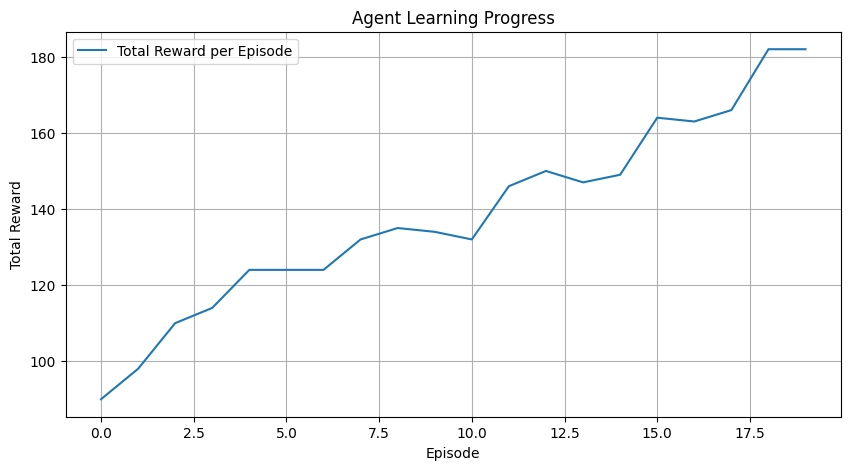

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Learning Progress')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
for e in range(10):  

    state, _ = env.reset()  # Unpack the state from the tuple 
    state = np.reshape(state, [1, state_size])  # Reshape the state correctly 
    for time in range(500):  
        env.render()  
        action = np.argmax(model.predict(state)[0])  
        next_state, reward, terminated, truncated, _ = env.step(action)  # Unpack the five return values 
        done = terminated or truncated  # Check if the episode is done 
        next_state = np.reshape(next_state, [1, state_size])  
        state = next_state  
        if done:  
            print(f"episode: {e+1}/10, score: {time}")  
            break  

env.close() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
episode: 1/10, score: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Experiment with Different Network Architectures

In [30]:
def build_model1(state_size, action_size):
    model = Sequential()
    model.add(Input(shape=(state_size,)))  # Explicit Input layer
    model.add(Dense(32, activation='relu'))  # Smaller hidden layers
    model.add(Dense(32, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


# Re-initialize the model with the new architecture
model1 = build_model1(state_size, action_size)

batch_size=32
def replay(batch_size):
    minibatch = random.sample(memory, batch_size)
    states = np.vstack([sample[0] for sample in minibatch])
    next_states = np.vstack([sample[3] for sample in minibatch])
    targets = model1.predict(states)
    target_next = model1.predict(next_states)
    for i, (state, action, reward, next_state, done) in enumerate(minibatch):
        target = reward if done else reward + 0.95 * np.amax(target_next[i])
        targets[i][action] = target
    model1.fit(states, targets, epochs=1, verbose=0)

episode_rewards = []
episodes=10
for e in range(episodes):
    state, _ = env.reset()  # Unpack the state from the tuple
    state = np.reshape(state, [1, state_size])
    for time in range(200):  # Reduced number of steps per episode
        action = act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{episodes}, score: {time}")
            break
        if len(memory) > batch_size and time % 10 == 0:  # Train every 10 steps
            replay(batch_size)  # Pass the batch size to replay()
    episode_rewards.append(total_reward)
env.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
episode: 1/10, score: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

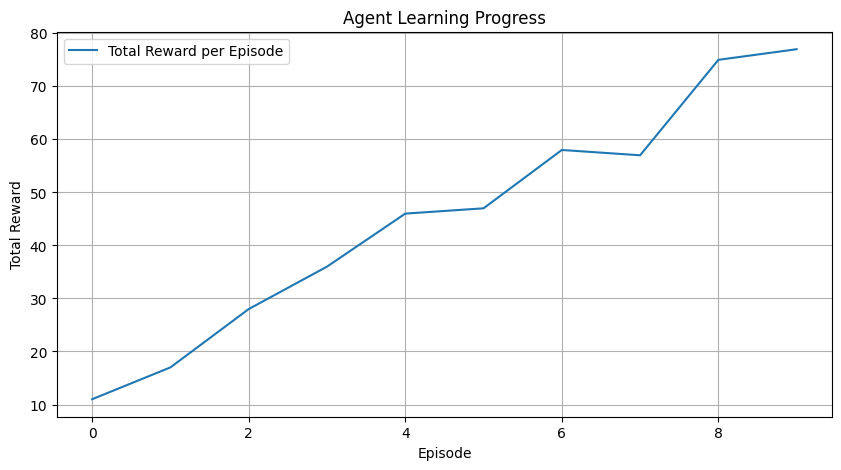

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Learning Progress')
plt.legend()
plt.grid(True)
plt.show()

## Implement an Adaptive Exploration Rate

In [15]:
def adjust_epsilon(score, consecutive_success_threshold=200):
    global epsilon 

    if score >= consecutive_success_threshold: 
        epsilon = max(epsilon_min, epsilon * 0.9)  # Reduce epsilon faster if performance is good
    else: 
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

In [16]:
episodes = 2

# Train the model with adaptive epsilon decay
for e in range(episodes): 
    state = env.reset()  
    state = state[0]
    state = np.reshape(state, [1, len(state)])
    total_reward = 0 

    for time in range(500):
        action = act(state)
        next_state, reward, done, truncated, _ = env.step(action)

        reward = reward if not done else -10
        total_reward += reward

        next_state = np.reshape(next_state, [1, len(next_state)])

        remember(state, action, reward, next_state, done)
        state = next_state

        if done or truncated:
            adjust_epsilon(total_reward)
            print(f"episode: {e}/{episodes}, score: {time}, e: {epsilon:.2}")
            break

        if len(memory) > batch_size:
            replay(batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

## Implement a Custom Reward Function

In [17]:
def custom_reward(state):
    # x (cart position), x_dot (cart velocity), theta (pole angle), theta_dot (pole angular velocity)
    x, x_dot, theta, theta_dot = state
    # Encourage the agent to keep the cart near the center and the pole upright
    reward = (1 - abs(x) / 2.4) + (1 - abs(theta) / 0.20948)
    return reward

In [34]:
episodes = 2
for e in range(episodes): 
    state = env.reset()
    print(f"State: {state}, State Type: {type(state)}")
    if isinstance(state, tuple):
        state = state[0]
    
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        reward = custom_reward(next_state) if not done else -10
        if isinstance(next_state, tuple):
            next_state = next_state[0]

        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)
        state = next_state

        if done or truncated:
            print(f"episode: {e}/{episodes}, score: {time}, e: {epsilon:.2}")
            break

        if len(memory) > batch_size:
            replay(batch_size)

State: (array([-0.01015598,  0.01024183, -0.01505325,  0.04751508], dtype=float32), {}), State Type: <class 'tuple'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━